<a href="https://colab.research.google.com/github/cybunayog/CS495-ML-Classification/blob/main/CS495_ML_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unique Dataset Assignment - Classification

## 1. Initial imports, files etc

Dataset used from https://archive.ics.uci.edu/ml/datasets/Speaker+Accent+Recognition

***Abstract***: Data set featuring single English words read by speakers from six different countries for accent detection and recognition

In [ ]:
# Mount your Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Copy the dataset and supporting Python file(s) to the local directory
!cp '/content/drive/MyDrive/Colab Notebooks/confusion_matrix_pretty_print.py' .
!cp '/content/drive/MyDrive/Colab Notebooks/accent.csv' .

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import math
from IPython import display

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing # Label encoding & Data scaling

# Import method from file (I made chagnes so that it didn't have depricated methods)
# File/package sourced from: http://github.com/wcipriana/pretty-print-confusion-matrix
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix

############################################
## ABOUT THE DATASET
## Attribute Information:

## Response variable:
## language = {ES, FR, GE, IT, UK, US} The six possible accents considered

## Explanatory variables:
## X1, X2, ..., X12 Obtained using MFCC on the original time domain soundtrack of the maximum 1s of reading of a word
############################################


# Test that Pandas is installed and imported
pd.__version__
# Load dataset
df_accent = pd.read_csv("accent.csv")


##1.5. Display Non-numeric Data

In [ ]:
labels = df_accent["language"].unique()
print(labels)

['ES' 'FR' 'GE' 'IT' 'UK' 'US']


## 2. Pre-process data

Encode String labels

In [ ]:
# Generate label encoder object
label_enc = preprocessing.LabelEncoder()
# # Convert Strings to ints and print unique ints
df_accent["language"] = label_enc.fit_transform(df_accent["language"])
df_accent["language"].unique()
df_accent["language"].describe()


count    329.000000
mean       3.601824
std        1.743314
min        0.000000
25%        2.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: language, dtype: float64

## 3. Randomize Data

In [ ]:
# Randomize ordering of all samples
df_accent = df_accent.reindex(np.random.permutation(df_accent.index))
df_accent.head(n = 10)
# Save randomized data to file and print the first few to show randomization
df_accent.to_csv("accent_RANDOMIZED.csv", index = False)

## 4. Select Columns for Features & Labels

We're creating a function that gets the features from a dataframe

In [ ]:
# Takes in a Pandas DataFrame taht contains a raw dataset and returns a
# Pandas DataFrame that contains only the selected features used for a model
def get_features_dataframe(df_input):
    
    # Create a new/blank DataFrame
    df_selected = pd.DataFrame()

    # Grab any features already available
    df_selected["X1"] = df_input["X1"]
    df_selected["X2"] = df_input["X2"]
    df_selected["X3"] = df_input["X3"]
    df_selected["X4"] = df_input["X4"]
    df_selected["X5"] = df_input["X5"]
    df_selected["X6"] = df_input["X6"]
    df_selected["X7"] = df_input["X7"]
    df_selected["X8"] = df_input["X8"]
    df_selected["X9"] = df_input["X9"]
    df_selected["X10"] = df_input["X10"]
    df_selected["X11"] = df_input["X11"]
    df_selected["X12"] = df_input["X12"]


    # Make a copy of the selected features
    df_processed = df_selected.copy()
        
    # Return the selected features
    return df_processed
    
# Takes in a Pandas DataFrame that contains a raw dataset and returns a
# Pandas DataFrame that contains only the selected target(s) used for a model
def get_targets_dataframe(df_input):
    
    # Create a new/blank DataFrame
    df_selected = pd.DataFrame()
        
    # Grab any features already available
    df_selected["language_label"] = df_input["language"]
        
    # Make a copy of the selected features
    df_processed = df_selected.copy()
        
    # Create any desired synthetic features
    # Do nothing
        
    # Return the selected features
    return df_processed

## 5. Seperate Data into Training

Select the percentage of data to be used for classic test/validation split training, and number of folds for cross-validation. Lastly seperate the data into training & validation sets by setting the percentage of data to be used for training.

In [ ]:
# Percentage (0-1.0 corresponds to 0% to 100%) of dataset
percent_training_data = 0.8       # THIS CAN BE CHANGED
percent_validation_data = 1 - percent_training_data
num_cv_folds = 5                  # THIS CAN BE CHANGED

# Choose the first (percent_training_data)% examples for training
num_total_examples = len(df_accent)
num_training_examples = math.ceil(num_total_examples * percent_training_data)
num_validation_examples = num_total_examples - num_training_examples

# Get all examples (useful later on...)
df_features_all = get_features_dataframe(df_accent.head(num_total_examples))
df_targets_all = get_targets_dataframe(df_accent.head(num_total_examples))

# Choose the first (percent_training_data)% for training examples
df_features_training = get_features_dataframe(df_accent.head(num_training_examples))
df_targets_training = get_targets_dataframe(df_accent.head(num_training_examples))

# Choose the last (1-percent_training_data)% for validation examples
df_features_validation = get_features_dataframe(df_accent.tail(num_validation_examples))
df_targets_validation = get_targets_dataframe(df_accent.tail(num_validation_examples))

## 6. Display Summary of Training/Testing Data (SANITY CHECK)

Print out basic stats of the training and validation data for both the features and targets/labels. Means (averages) between the training and validation features/targets should be close if data was properly randomized:

In [ ]:
print("{} total examples used:".format(num_total_examples))
print("\t{:2f}% ({} examples used for training)".format(num_training_examples/num_total_examples * 100, num_training_examples))
print("\t{:2f}% ({} examples used for validation)".format(num_validation_examples/num_total_examples * 100, num_validation_examples))

# Display summary of features data
print("\nTraining features summary:")
display.display(df_features_training.describe())
print("\nValidation features summary:")
display.display(df_features_validation.describe())

# Display summary of labels/targets data
print("\nTraining targets/labels summary:")
display.display(df_targets_training.describe())
print("\nValidation targets/labels summary:")
display.display(df_targets_validation.describe())

329 total examples used:
	80.243161% (264 examples used for training)
	19.756839% (65 examples used for validation)

Training features summary:


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,5.453850,-4.203285,2.742917,7.109513,-5.369682,9.608574,-9.287419,5.228370,-1.505203,-2.007794,2.297252,-3.994847
std,5.160907,3.496156,3.760598,4.416901,4.791884,3.799691,2.500615,2.697592,3.831420,5.215414,3.656008,3.075396
min,-6.067831,-14.972962,-6.186583,-8.844231,-15.656596,-3.528964,-15.365665,-2.873862,-15.510974,-11.429178,-13.664104,-13.724103
25%,1.765770,-6.547759,0.221745,4.698031,-8.170713,8.592402,-10.964582,3.592919,-1.887586,-4.883340,1.075051,-5.942717
50%,4.890062,-4.236137,2.058350,7.823434,-6.726570,10.154266,-9.637805,4.907732,-0.460820,-3.194993,2.917574,-4.352679
75%,9.464616,-1.559771,4.489976,10.084355,-4.099702,11.693217,-7.772624,6.613092,0.611950,-1.173916,4.623666,-2.241415
max,16.971161,3.570765,17.066487,15.167421,7.912809,21.445837,-0.424033,13.846083,4.789989,16.326455,9.166066,5.259430



Validation features summary:


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,6.422513,-4.545082,2.198305,7.568562,-6.782108,10.629298,-9.898013,4.666327,-0.109376,-3.802078,2.973376,-3.921797
std,4.833304,3.601744,3.061520,3.855527,3.504148,2.674702,2.371809,2.417737,2.408242,3.985888,2.590571,2.611656
min,-2.339695,-14.294344,-3.780587,-1.452419,-12.707176,2.285331,-14.508959,-0.999699,-6.959334,-10.619704,-7.693155,-8.957588
25%,3.181085,-6.245275,0.034879,4.740558,-8.973376,9.464657,-11.495180,3.134385,-1.143527,-6.056621,2.098567,-5.887197
50%,5.777123,-4.485605,1.982669,7.716523,-7.057811,11.177197,-10.152215,4.508178,0.062097,-3.529834,3.551976,-4.705593
75%,10.421391,-1.875598,3.745731,10.533946,-6.151054,12.138615,-8.452480,6.502105,1.336222,-2.813602,4.958958,-2.044517
max,17.749851,1.749341,11.773680,16.178942,4.479836,15.525385,-2.321599,10.243983,4.041681,10.167614,7.199020,3.028161



Training targets/labels summary:


,language_label
count,264.000000
mean,3.590909
std,1.735141
min,0.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000



Validation targets/labels summary:


,language_label
count,65.000000
mean,3.646154
std,1.789123
min,0.000000
25%,2.000000
50%,5.000000
75%,5.000000
max,5.000000


## 7. Standardize Data & Display (SANITY CHECK)
Standardize all feature data so that it looks like Gaussian distribution with 0 MEAN and UNIT 1 variation (standard deviation). Display results for sanity check:

In [ ]:
# Create scalar from training examples and normalize both training and validation examples
scaler = preprocessing.StandardScaler().fit(df_features_training)
df_features_training_normalized = pd.DataFrame(scaler.transform(df_features_training))
df_features_validation_normalized = pd.DataFrame(scaler.transform(df_features_validation))

# Display summary of feature data
print("\nTraining Features Summary:")
display.display(df_features_training_normalized.describe())
print("\nValidation Features Summary:")
display.display(df_features_validation_normalized.describe())
# For more tips on scaling data in SCIKIT-LEARN:
# https://scikit-learn.org/stable/modules/preprocessing.html

# NOTE: Validation data won't have the same closeness to 0 MEAN and 1 STD b/c the scaler was created on the training data


Training Features Summary:


,0,1,2,3,4,5,6,7,8,9,10,11
count,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02,2.640000e+02
mean,-5.761385e-17,-1.261617e-17,-1.070797e-16,-9.335966e-17,-1.841961e-16,-1.042937e-16,-1.741032e-16,1.017704e-16,-1.009294e-17,-8.494888e-17,6.266031e-17,-8.663104e-17
std,1.001899e+00,1.001899e+00,1.001899e+00,1.001899e+00,1.001899e+00,1.001899e+00,1.001899e+00,1.001899e+00,1.001899e+00,1.001899e+00,1.001899e+00,1.001899e+00
min,-2.236732e+00,-3.086284e+00,-2.378999e+00,-3.618837e+00,-2.150814e+00,-3.464095e+00,-2.435317e+00,-3.009210e+00,-3.662447e+00,-1.809881e+00,-4.374080e+00,-3.169587e+00
25%,-7.159759e-01,-6.718597e-01,-6.716911e-01,-5.470039e-01,-5.856467e-01,-2.679433e-01,-6.719744e-01,-6.074150e-01,-9.999131e-02,-5.524025e-01,-3.349344e-01,-6.345751e-01
50%,-1.094496e-01,-9.414474e-03,-1.823825e-01,1.619407e-01,-2.837017e-01,1.438876e-01,-1.403862e-01,-1.190865e-01,2.731017e-01,-2.280652e-01,1.699941e-01,-1.165740e-01
75%,7.786195e-01,7.575565e-01,4.654520e-01,6.747924e-01,2.655307e-01,5.496771e-01,6.069195e-01,5.142927e-01,5.536263e-01,1.601908e-01,6.375350e-01,5.712313e-01
max,2.235883e+00,2.227823e+00,3.816089e+00,1.827800e+00,2.777137e+00,3.121240e+00,3.551215e+00,3.200662e+00,1.646165e+00,3.522074e+00,1.882343e+00,3.014849e+00



Validation Features Summary:


,0,1,2,3,4,5,6,7,8,9,10,11
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,0.188049,-0.097949,-0.145096,0.104127,-0.295314,0.269144,-0.244642,-0.208746,0.365003,-0.344688,0.185286,0.023798
std,0.938301,1.032158,0.815651,0.874561,0.732656,0.705263,0.950292,0.897960,0.629745,0.765703,0.709925,0.850823
min,-1.512980,-2.891812,-1.737993,-1.942129,-1.534142,-1.930987,-2.092068,-2.313136,-1.426231,-1.654378,-2.737790,-1.616757
25%,-0.441217,-0.585176,-0.721476,-0.537357,-0.753470,-0.037948,-0.884564,-0.777717,0.094577,-0.777794,-0.054448,-0.616488
50%,0.062758,-0.080905,-0.202545,0.137690,-0.352958,0.413613,-0.346490,-0.267483,0.409842,-0.292389,0.343847,-0.231546
75%,0.964361,0.667049,0.267170,0.776775,-0.163371,0.667119,0.334528,0.473072,0.743020,-0.154799,0.729419,0.635377
max,2.387052,1.705854,2.405978,2.057246,2.059362,1.560140,2.790934,1.862824,1.450486,2.338939,1.343290,2.287949


## 8. Create Classification Models

Logistic Regression, SVC, LVC, KNN, Bernoulli Naive Bayes, Decision Tree Classifier

In [ ]:
# Variables to hold multiple models
list_model_names = [
                    "Logistic Regression (LR)", 
                    "Support Vector Classifier (SVC)",  
                    "Linear Support Vector Classifier (LSVC)",  
                    "K-nearest Neighbors (KNN)", 
                    "Bernoulli Naive Bayes (BNB)",
                    "Decision Tree Classifier (DTC)"
                    ]
list_models = []
list_model_predictions = []

# Associated data
list_model_cm = []
list_model_accuracy = []
list_model_precision = []
list_model_recall = []
list_model_fscore = []

## 9. Train Data

In [ ]:
print("Model Parameters:", end="\n\n\t")
X = df_features_training_normalized
Y = df_targets_training.to_numpy().ravel()

# Train/fit Logistic Regression Model
from sklearn import linear_model
logistic = linear_model.LogisticRegression(solver="lbfgs", max_iter=12000, multi_class="multinomial")
logistic.fit(X, Y)
list_models.append(logistic)
print(logistic, end="\n\n\t")

# Train/fit Support Vector Classification Model
from sklearn import svm
svc = svm.SVC(kernel="linear", class_weight="balanced", max_iter=10000)
svc.fit(X, Y)
list_models.append(svc)
print(svc, end="\n\n\t")

# Train/fit Linear Support Vector Classification Model
lsvc = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=False, max_iter=10000)
lsvc.fit(X, Y)
list_models.append(lsvc)
print(lsvc, end="\n\n\t")

# Train/fit K-nearest Neighbors Model
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
knn.fit(X, Y)
list_models.append(knn)
print(knn, end="\n\n\t")

# Train/fit 2 new models
## Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(X, Y)
list_models.append(bnb)
print(bnb, end="\n\n\t")

## Decision Trees
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc.fit(X, Y)
list_models.append(dtc)
print(dtc, end="\n\n\t")


Model Parameters:

	LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=12000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

	SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=10000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

	LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

	KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2

## 10. Make Predictions

In [ ]:
# Predict validation examples and print
for i in range(len(list_model_names)):  
  prediction = list_models[i].predict(df_features_validation_normalized)
  list_model_predictions.append(prediction)
  print("{} Predictions:".format(list_model_names[i]))

  # Print prediction and validation labels
  print("\t{}<== PREDICTION".format(prediction))
  print("\t{}<== ACTUAL".format(df_targets_validation.to_numpy().ravel()))

Logistic Regression (LR) Predictions:
	[0 3 5 5 3 0 4 3 2 1 5 5 5 5 0 5 5 4 0 5 5 5 1 5 4 5 1 5 2 3 4 5 1 1 5 5 2
 5 2 5 1 5 5 5 4 1 5 5 5 5 5 4 5 2 5 0 5 4 5 5 5 4 5 4 5]<== PREDICTION
	[5 5 5 5 5 0 4 1 2 5 4 5 5 0 0 5 5 4 0 5 5 5 5 5 4 2 5 5 5 3 4 5 5 1 2 5 2
 3 2 5 1 5 5 3 4 1 5 5 5 5 5 0 5 2 4 0 5 4 5 5 4 4 5 0 2]<== ACTUAL
Support Vector Classifier (SVC) Predictions:
	[0 3 1 5 3 0 4 1 2 2 1 5 1 0 0 5 0 4 0 3 5 5 1 5 4 2 1 3 3 3 1 5 1 1 5 5 2
 5 2 4 1 1 5 3 4 1 1 2 1 5 5 0 0 2 2 0 2 4 5 5 1 4 5 4 2]<== PREDICTION
	[5 5 5 5 5 0 4 1 2 5 4 5 5 0 0 5 5 4 0 5 5 5 5 5 4 2 5 5 5 3 4 5 5 1 2 5 2
 3 2 5 1 5 5 3 4 1 5 5 5 5 5 0 5 2 4 0 5 4 5 5 4 4 5 0 2]<== ACTUAL
Linear Support Vector Classifier (LSVC) Predictions:
	[0 5 5 5 3 0 4 3 2 1 5 5 5 5 0 5 5 4 0 5 5 5 1 5 4 5 2 5 2 5 4 5 1 1 5 5 2
 5 2 5 1 5 5 5 4 1 5 5 5 5 5 4 5 2 5 0 5 4 5 5 5 4 5 4 5]<== PREDICTION
	[5 5 5 5 5 0 4 1 2 5 4 5 5 0 0 5 5 4 0 5 5 5 5 5 4 2 5 5 5 3 4 5 5 1 2 5 2
 3 2 5 1 5 5 3 4 1 5 5 5 5 5 0 5 2 4 0 5 4 5 5 4 4 5 0 2

## 11. Generate Confusion Matrices, and other Analytics

In [ ]:
# Generate confusion matrices & analytics
for i in range(len(list_model_names)):
  # confusion matrices
  cm = confusion_matrix(df_targets_validation, list_model_predictions[i])
  list_model_cm.append(cm)

  # accuracy
  acc = accuracy_score(df_targets_validation, list_model_predictions[i])
  list_model_accuracy.append(acc)

  # precision
  precision = precision_score(df_targets_validation, list_model_predictions[i], average='micro')
  list_model_precision.append(precision)

  # recall
  recall = recall_score(df_targets_validation, list_model_predictions[i], average='micro')
  list_model_recall.append(recall)

  # f score
  fscore = f1_score(df_targets_validation, list_model_predictions[i], average='micro')
  list_model_fscore.append(fscore)

## 12. Display Basic Summary

In [ ]:
# Print correctness of each model
for i in range(len(list_model_names)):
    print("{} Prediction Accuracy: ".format(list_model_names[i]))
    
    # Print results for classic split of test and validation data
    print("\tResults for classic {:.0f}/{:.0f} (training/testing) split:".format(percent_training_data * 100, percent_validation_data * 100))
    overall_score = list_models[i].score(df_features_validation_normalized, df_targets_validation)
    print("\t\tOverall: {:.2f}%".format(overall_score * 100))

    # Print out scores for individual accents
    for j in range(len(labels) - 1):
      print("\t\t\tLanguage {:s}: {:.2f}%".format(labels[j], list_model_cm[i][j][j] / sum(list_model_cm[i][j]) * 100))

    # Print results for cross-validation
    cv_results  = cross_val_score(list_models[i], df_features_all, df_targets_all.to_numpy().ravel(), cv=num_cv_folds)
    print("\tResults for classic {:d}-fold cross-validation:".format(num_cv_folds))
    print("\t\tOverall: {:.2f}%\n".format(np.mean(cv_results) * 100))

Logistic Regression (LR) Prediction Accuracy: 
	Results for classic 80/20 (training/testing) split:
		Overall: 69.23%
			Language ES: 57.14%
			Language FR: 75.00%
			Language GE: 57.14%
			Language IT: 33.33%
			Language UK: 70.00%
	Results for classic 5-fold cross-validation:
		Overall: 71.10%

Support Vector Classifier (SVC) Prediction Accuracy: 
	Results for classic 80/20 (training/testing) split:
		Overall: 58.46%
			Language ES: 85.71%
			Language FR: 100.00%
			Language GE: 85.71%
			Language IT: 66.67%
			Language UK: 60.00%
	Results for classic 5-fold cross-validation:
		Overall: 65.65%

Linear Support Vector Classifier (LSVC) Prediction Accuracy: 
	Results for classic 80/20 (training/testing) split:
		Overall: 69.23%
			Language ES: 57.14%
			Language FR: 75.00%
			Language GE: 57.14%
			Language IT: 0.00%
			Language UK: 70.00%
	Results for classic 5-fold cross-validation:
		Overall: 71.11%

K-nearest Neighbors (KNN) Prediction Accuracy: 
	Results for classic 80/20 (training

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


## 13. Display Confusion Matrices

The following code generates and dispalys the confusion matrix of the previous predictions:

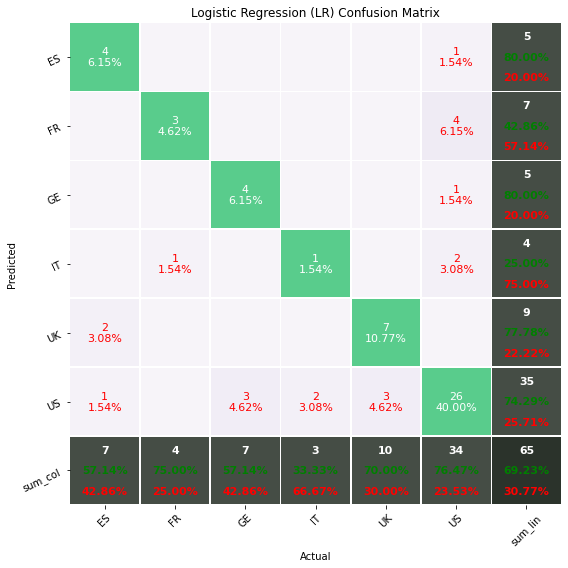

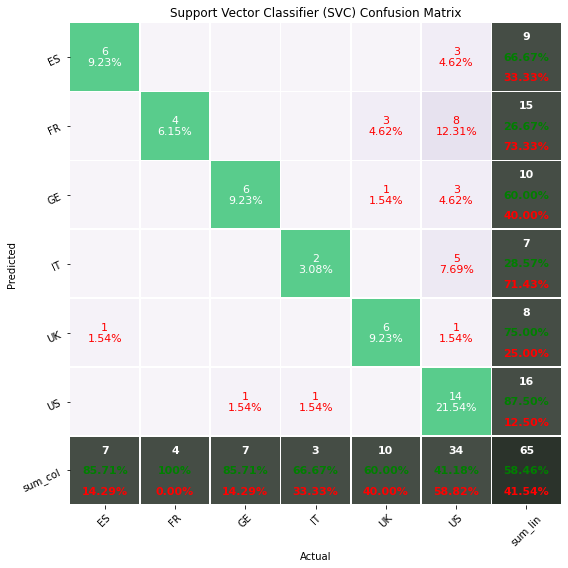

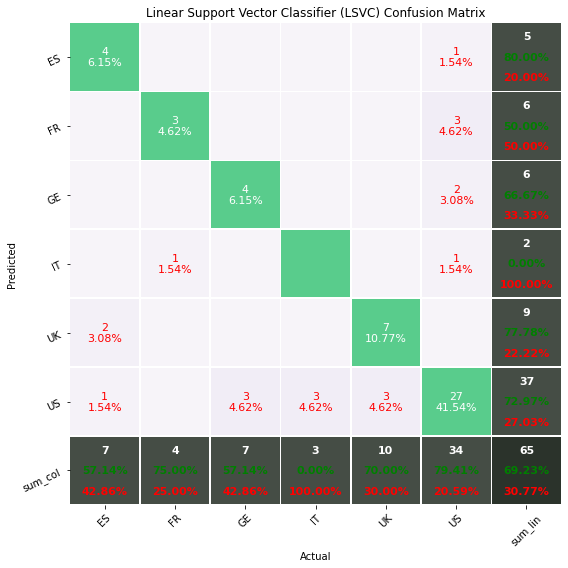

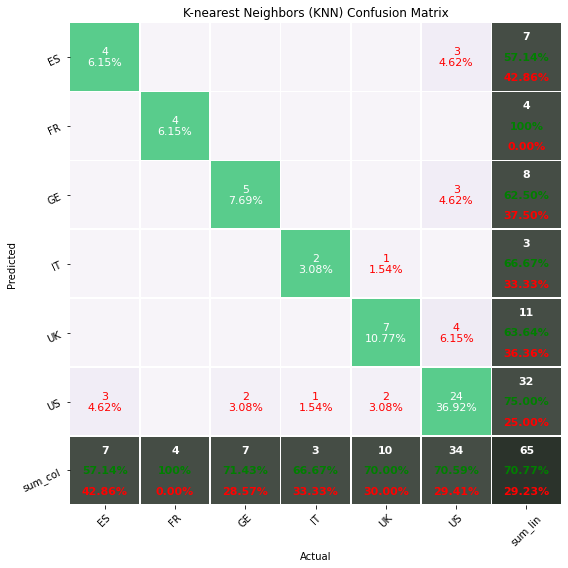

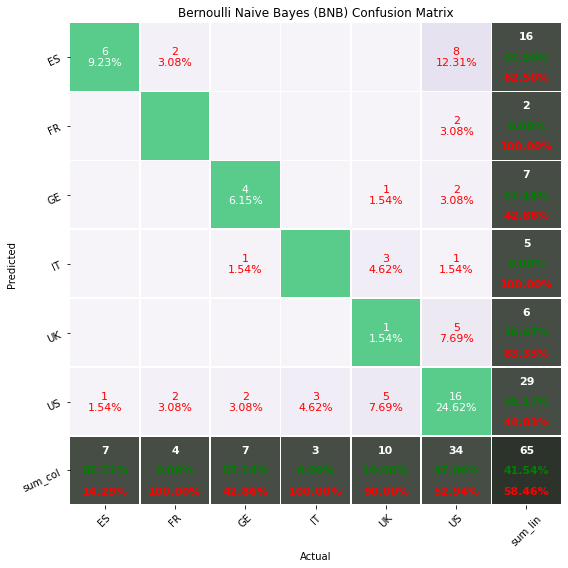

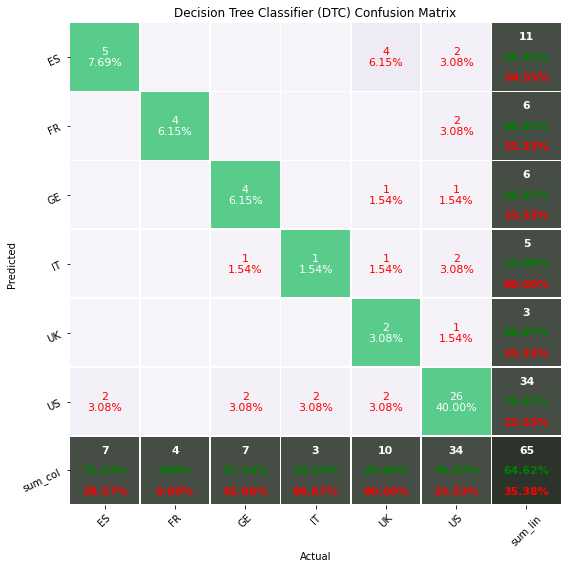

In [ ]:
# Print confusion matrices    
for i in range(len(list_model_names)):
  title = "{} Confusion Matrix".format(list_model_names[i])
  df_cm = pd.DataFrame(list_model_cm[i], index=labels, columns=labels)
  pretty_plot_confusion_matrix(df_cm, cmap="PuRd", pred_val_axis="X", title=title)

## 14. Display Accuracy

In [ ]:
# Print Accuracy Metrics
for i in range(len(list_model_names)):
  print(list_model_accuracy[i])
  score = "Accuracy Score for {}: {:f}".format(list_model_names[i], list_model_accuracy[i])
  print(score, end="\n")

0.6923076923076923
Accuracy Score for Logistic Regression (LR): 0.692308
0.5846153846153846
Accuracy Score for Support Vector Classifier (SVC): 0.584615
0.6923076923076923
Accuracy Score for Linear Support Vector Classifier (LSVC): 0.692308
0.7076923076923077
Accuracy Score for K-nearest Neighbors (KNN): 0.707692
0.4153846153846154
Accuracy Score for Bernoulli Naive Bayes (BNB): 0.415385
0.6461538461538462
Accuracy Score for Decision Tree Classifier (DTC): 0.646154


## 15. Display Precision

In [ ]:
for i in range(len(list_model_names)):
  score = "Precision Score for {}: {:f}".format(list_model_names[i], list_model_precision[i][i])
  print(score, end="\n")

Precision Score for Logistic Regression (LR): 0.800000
Precision Score for Support Vector Classifier (SVC): 0.266667
Precision Score for Linear Support Vector Classifier (LSVC): 0.666667
Precision Score for K-nearest Neighbors (KNN): 0.666667
Precision Score for Bernoulli Naive Bayes (BNB): 0.166667
Precision Score for Decision Tree Classifier (DTC): 0.764706


## 16. Display Recall

In [ ]:
for i in range(len(list_model_names)):
  score = "Recall Score for {}: {:f}".format(list_model_names[i], list_model_recall[i][i])
  print(score, end="\n")

Recall Score for Logistic Regression (LR): 0.571429
Recall Score for Support Vector Classifier (SVC): 1.000000
Recall Score for Linear Support Vector Classifier (LSVC): 0.571429
Recall Score for K-nearest Neighbors (KNN): 0.666667
Recall Score for Bernoulli Naive Bayes (BNB): 0.100000
Recall Score for Decision Tree Classifier (DTC): 0.764706


## 17. Display F-Score

In [ ]:
for i in range(len(list_model_names)):
  score = "F Score for {}: {:f}".format(list_model_names[i], list_model_fscore[i][i])
  print(score, end="\n")

F Score for Logistic Regression (LR): 0.666667
F Score for Support Vector Classifier (SVC): 0.421053
F Score for Linear Support Vector Classifier (LSVC): 0.615385
F Score for K-nearest Neighbors (KNN): 0.666667
F Score for Bernoulli Naive Bayes (BNB): 0.125000
F Score for Decision Tree Classifier (DTC): 0.764706
